This notebook aims to go through the necessary steps to generate the plots in Figure2. 
For each method (genes, VAE, and MLP), we plot:
 - the UMAP distributions 
 - the parcellated similarity matrices
 - the unit-scaled, rank ordered similarity profiles for each region

In [1]:
import pandas as pd
import numpy as np
import os
import nibabel as nib
import nilearn
import nilearn.plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import neuromaps
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from neuromaps import nulls, transforms, resampling
from neuromaps import stats as nm_stats
from neuromaps.datasets import fetch_annotation

from nilearn import surface, datasets

def mirror_brain(half_map):
    human_brain = nib.load('data/mouse_human/data.ign/full_atlas_129_regions_resampled_2mm.nii.gz').get_fdata()
    affine = nib.load('data/mouse_human/data.ign/full_atlas_129_regions_resampled_2mm.nii.gz').affine
    
    human_map = human_brain.copy()
    human_half_map = human_map[0:50,:,:]
    human_half_map[human_half_map>0] = half_map
    human_map[0:50,:,:]=human_half_map
    human_map[50:,:,:]=np.flip(human_half_map[1:49,:,:], axis=0)
    
    map_ = nib.Nifti1Image(human_map, affine)
    return map_


def plot_human_surf(mask_nii_h):
    fsaverage = datasets.fetch_surf_fsaverage(mesh="fsaverage5")
    hemi= "left"
    radius = 8
    kind = 'ball'
    depth = 0.7
    inter='linear'
    n_samples=160
    pial_mesh = fsaverage[f"pial_{hemi}"]
    infl_mesh = fsaverage[f"infl_{hemi}"]
    X = surface.vol_to_surf(mask_nii_h, pial_mesh, radius=radius, interpolation=inter, n_samples=n_samples, kind=kind).T
    X = (X - X.min()) /(X.max() - X.min())
    nilearn.plotting.plot_surf_stat_map(infl_mesh,X,view=("lateral"), cmap='jet', colorbar=True)
    nilearn.plotting.plot_surf_stat_map(infl_mesh,X, view=("medial"), cmap='jet')


In [2]:
# Load the data from the MLP embeddings, the VAE embeddings, and the gene expression data

mlp_h=pd.read_csv('exps/e2_mlp/results.ign/testrun//encoding/human_region129_encoding.csv')
mlp_m = pd.read_csv('exps/e2_mlp/results.ign/testrun/encoding/mouse_region_encoding.csv')

vae_h = pd.read_csv('exps/e3_vae/results.ign/sweep_result/encoding/human_dense_region129_encoding.csv.mu.csv')
vae_m = pd.read_csv('exps/e3_vae/results.ign/sweep_result/encoding/mouse_region_encoding.csv.mu.csv')

gene_m = pd.read_csv('data/mouse_human/data.ign/MouseExpressionMatrix_ROI_Region67_scaled.csv')
gene_h = pd.read_csv('data/mouse_human/data.ign/human_dense_maps_parcellated_scaled.csv')

labels_img='data/mouse_human/data.ign/full_atlas_129_regions_resampled_2mm.nii.gz'
labels_nib = nib.load(labels_img)
labels_dat = labels_nib.get_fdata()
shape_dat = labels_dat.shape
labels_aff = labels_nib.affine

In [3]:
mlp_h_data = mlp_h.iloc[:,:-1]
mlp_m_data = mlp_m.iloc[:,:-1]
vae_h_data = vae_h.iloc[:,:-1]
vae_m_data = vae_m.iloc[:,:-1]
genes_m_data = gene_m.iloc[:,1:]
genes_h_data = gene_h.iloc[:,1:-1]

In [4]:
# scaling: zscore columns and center
scale=StandardScaler()
center = StandardScaler(with_std=False)

genes_h_data_scaled = scale.fit_transform(genes_h_data.T)
genes_h_data_centered = center.fit_transform(genes_h_data_scaled.T)
genes_h_data=pd.DataFrame(genes_h_data_centered)

genes_m_data_scaled = scale.fit_transform(genes_m_data.T)
genes_m_data_centered = center.fit_transform(genes_m_data_scaled.T)
genes_m_data=pd.DataFrame(genes_m_data_centered)

mlp_m_data = pd.DataFrame(center.fit_transform(scale.fit_transform(mlp_m_data.T).T))
mlp_h_data = pd.DataFrame(center.fit_transform(scale.fit_transform(mlp_h_data.T).T))

vae_h_data = pd.DataFrame(center.fit_transform(scale.fit_transform(vae_h_data.T).T))
vae_m_data = pd.DataFrame(center.fit_transform(scale.fit_transform(vae_m_data.T).T))

In [34]:
# Reorder mouse matrix
mouse_labels_order = pd.read_csv("data/mouse_human/data.ign/reordered_mouse.csv")
reorder = np.where(mouse_labels_order.values==np.array(mlp_m.iloc[:,-1]))

mouse_all_regions = pd.read_csv('data/mouse_human/data.ign/mouse_all_regions_voxels.csv')

mouse_5 = mouse_all_regions['Region5']
mouse_11 = mouse_all_regions['Region11']
mouse_28 = mouse_all_regions['Region28']
mouse_46 = mouse_all_regions['Region46']
mouse_67 = mouse_all_regions['Region67']

region_5, ind5 = np.unique(mouse_5, return_index=True)
region_11, ind11 = np.unique(mouse_11, return_index=True)
region_67, ind67 = np.unique(mouse_67, return_index=True)
list_5 = [mouse_5[i] for i in ind67]
list_11 = [mouse_11[i] for i in ind67]
list_67 = [mouse_67[i] for i in ind67]
m11 = pd.DataFrame(list_11).reindex(reorder[1])
m5 = pd.DataFrame(list_5).reindex(reorder[1])
m67 = pd.DataFrame(list_67).reindex(reorder[1])
m67 = m67.reset_index()
m5 = m5.reset_index()
m11=m11.reset_index()
mouse_5 = m5
mouse_11 = m11
mouse_67 = m67

mouse_5[mouse_11=='Isocortex']='Cortex'
mouse_5[mouse_11=='Cortical subplate']='Subcortex'
mouse_5[mouse_11=='Olfactory areas']='Cortex'
mouse_5[mouse_11=='Cerebellar cortex']='Cerebellum'
mouse_5[mouse_11=='Cerebellar nuclei']='Cerebellum'
mouse_5[mouse_11=='Hippocampal formation']='Hippocampus'
mouse_5[mouse_11=='Midbrain']='Brainstem'
mouse_5[mouse_11=='Medulla']='Brainstem'
mouse_5[mouse_11=='Pons']='Brainstem'
mouse_5[mouse_11=='Interbrain']='Subcortex'
mouse_5[mouse_11=='Cerebral nuclei']='Subcortex'

mouse_67[0][mouse_5[0]=='Cortex']

mouse_5[mouse_67=='Olfactory areas-other']='Cortex - association'
mouse_5[mouse_67=='Postpiriform transition area']='Cortex - limbic'
mouse_5[mouse_67=='Piriform area']='Cortex - limbic'
mouse_5[mouse_67=='Taenia tecta']='Cortex - limbic'
mouse_5[mouse_67=='Cortical amygdalar area']='Cortex - limbic'
mouse_5[mouse_67=='Piriform-amygdalar area']='Cortex - limbic'
mouse_5[mouse_67=='Main olfactory bulb']='Cortex - primary'
mouse_5[mouse_67=='Accessory olfactory bulb']='Cortex - association'
mouse_5[mouse_67=='Anterior olfactory nucleus']='Cortex - association'
mouse_5[mouse_67=='Anterior cingulate area']='Cortex - association'
mouse_5[mouse_67=='Infralimbic area']='Cortex - limbic'
mouse_5[mouse_67== 'Retrosplenial area']='Cortex - association'
mouse_5[mouse_67=='Prelimbic area']='Cortex - limbic'
mouse_5[mouse_67=='Primary auditory area']='Cortex - primary'
mouse_5[mouse_67=='Dorsal auditory area']='Cortex - association'
mouse_5[mouse_67=='Ventral auditory area']='Cortex - association'
mouse_5[mouse_67=='Agranular insular area']='Cortex - association'
mouse_5[mouse_67=='Ectorhinal area']='Cortex - limbic'
mouse_5[mouse_67=='Primary motor area']='Cortex - primary'
mouse_5[mouse_67=='Secondary motor area']='Cortex - association'
mouse_5[mouse_67=='Frontal pole, cerebral cortex']='Cortex - association'
mouse_5[mouse_67=='Orbital area']='Cortex - association'
mouse_5[mouse_67=='Posterior parietal association areas']='Cortex - association'
mouse_5[mouse_67=='Perirhinal area']='Cortex - limbic'
mouse_5[mouse_67=='Primary somatosensory area']='Cortex - primary'
mouse_5[mouse_67=='Supplemental somatosensory area']='Cortex - association'
mouse_5[mouse_67=='Temporal association areas']='Cortex - association'
mouse_5[mouse_67=='Visual areas']='Cortex - primary'


# sort mouse labels according to  cortex, subcortex/brainstem, cerebellum
index_mouse=[]
for region in ['Cortex - primary', 'Cortex - association', 'Cortex - limbic', 'Hippocampus', 'Subcortex', 'Brainstem','Cerebellum']:
    index_mouse.extend(np.where(mouse_5[0]==region)[0])
index_mouse = np.array(index_mouse)

In [24]:
# Reorder human matrix
human_rois = pd.read_csv('data/mouse_human/data.ign/atlas_ahba.csv')

# a few corrections
human_rois.loc[human_rois['Long label']=='supramarginal gyrus', "structure5"]='Cortex - association'
human_rois.loc[human_rois['Long label']=='planum temporale', "structure5"]='Cortex - association'
human_rois.loc[human_rois['Long label']=='piriform cortex', "structure5"]='Cortex - limbic'
human_rois.loc[human_rois['Long label']=='frontal agranular insular cortex', "structure5"]='Cortex - limbic'
human_rois.loc[human_rois['Long label']=='temporal agranular insular cortex', "structure5"]='Cortex - limbic'
human_rois.loc[human_rois['Long label']=='cingulate gyrus, rostral part', "structure5"]='Cortex - limbic'
human_rois.loc[human_rois['Long label']=='cingulate gyrus, caudal part', "structure5"]='Cortex - association'
human_rois.loc[human_rois['Long label']=='cingulo-parahippocampal isthmus', "structure5"]='Cortex - limbic'
human_rois.loc[human_rois['Long label']=='anterior parahippocampal gyrus', "structure5"]='Cortex - limbic'
human_rois.loc[human_rois['Long label']=='posterior parahippocampal gyrus', "structure5"]='Cortex - limbic'
human_rois.loc[human_rois['Long label']=='ambiens gyrus', "structure5"]='Cortex - limbic'
human_rois.loc[human_rois['Long label']=='parietal operculum', "structure5"]='Cortex - association'
human_rois.loc[human_rois['Long label']=='paracingulate gyrus', "structure5"]='Cortex - association'
human_rois.loc[human_rois['Long label']=='rostral gyrus', "structure5"]='Cortex - association'
human_rois.loc[human_rois['Long label']=='frontomarginal gyrus', "structure5"]='Cortex - association'
human_rois.loc[human_rois['Long label']=='frontal pole', "structure5"]='Cortex - association'
human_rois.loc[human_rois['Long label']=='perirhinal gyrus', "structure5"]='Cortex - association'


human_rois.loc[human_rois['Long label']=='olfactory bulb', "structure5"]='Cortex - primary'
human_rois.loc[human_rois['Long label']=='inferior occipital gyrus ', "structure5"]='Cortex - association'
human_rois.loc[human_rois['Long label']=='superior occipital gyrus', "structure5"]='Cortex - association'
human_rois.loc[human_rois['Long label']=='gyrus rectus', "structure5"]='Cortex - association'
human_rois.loc[human_rois['Long label']=='anterior intermediate orbital gyrus', "structure5"]='Cortex - association'
human_rois.loc[human_rois['Long label']=='posterior intermediate orbital gyrus', "structure5"]='Cortex - association'
human_rois.loc[human_rois['Long label']=='lateral intermediate orbital gyrus', "structure5"]='Cortex - association'
human_rois.loc[human_rois['Long label']=='paracentral lobule, caudal part', "structure5"]='Cortex - association'
human_rois.loc[human_rois['Long label']=='middle temporal gyrus', "structure5"]='Cortex - association'
human_rois.loc[human_rois['Long label']=='Inferior temporal gyrus', "structure5"]='Cortex - association'
human_rois.loc[human_rois['Long label']=='planum polare', "structure5"]='Cortex - association'
human_rois.loc[human_rois['Long label']=='lingual gyrus', "structure5"]='Cortex - association'
human_rois.loc[human_rois['Long label']=='limen insula', "structure5"]='Cortex - limbic'
human_rois.loc[human_rois['Long label']=='Short insular gyrus', "structure5"]='Cortex - association'
human_rois.loc[human_rois['Long label']=='superior temporal gyrus', "structure5"]='Cortex - association'

human_rois.loc[human_rois['Long label']=='precentral gyrus', "structure5"]='Cortex - primary'
human_rois.loc[human_rois['Long label']=='postcentral gyrus', "structure5"]='Cortex - primary'
human_rois.loc[human_rois['Long label']=='transverse temporal gyrus TTG', "structure5"]='Cortex - primary'
human_rois.loc[human_rois['Long label']=='occipital pole', "structure5"]='Cortex - primary'

human_rois.loc[human_rois['Long label']=='paracentral lobule, rostral part', "structure5"]='Cortex - association'
human_rois.loc[human_rois['Long label']=='paracentral lobule, caudal part', "structure5"]='Cortex - association'
human_rois.loc[human_rois['Long label']=='cuneus', "structure5"]='Cortex - association'

human_rois.loc[human_rois['Long label']=='anterior olfactory nucleus', "structure5"]='Subcortex'
human_rois.loc[human_rois['Long label']=='subcallosal gyrus', "structure5"]='Cortex - limbic'
human_rois.loc[human_rois['Long label']=='paracingulate gyrus ', "structure5"]='Cortex - association'
human_rois.loc[human_rois['Long label']=='lateral olfactory bulb ', "structure5"]='Subcortex'

human_rois.loc[human_rois["structure5"]=='Cortex - supramodal', "structure5"]='Cortex - association'

human_129 = human_rois['Long label']
human_3 = human_rois['structure']
human_5 = human_rois['structure5']

In [25]:
# sort human labels according to third column cortex, subcortex/brainstem, cerebellum
index_human=[]
for region in ['Cortex - primary', 'Cortex - association', 'Cortex - limbic','Hippocampus', 'Subcortex', 'Brainstem','Cerebellum']:
    index_human.extend(np.where(human_5==region)[0])

In [39]:
# Check KS statistic:

sim_vae = np.corrcoef(vae_h_data, vae_m_data)[0:len(mlp_h_data),-len(mlp_m_data):][:,reorder[1]]
sim_mlp = np.corrcoef(mlp_h_data, mlp_m_data)[0:len(mlp_h_data),-len(mlp_m_data):][:,reorder[1]]
sim_genes = np.corrcoef(genes_h_data, genes_m_data)[0:len(mlp_h_data),-len(mlp_m_data):][:,reorder[1]]

sim_vae = sim_vae[:,index_mouse]
sim_mlp = sim_mlp[:,index_mouse]
sim_genes = sim_genes[:,index_mouse]


sim_vae = sim_vae[index_human,:]
sim_mlp = sim_mlp[index_human,:]
sim_genes = sim_genes[index_human,:]


# check plots
#plt.imshow(sim_vae[:,reorder[1]])
# check stats
data_1 = pd.DataFrame({"MLP":np.sort(sim_mlp[:,1]), "VAE": np.sort(sim_vae[:,1]), 'genes': np.sort(sim_genes[:,1])})
data_ks=pd.melt(data_1, value_vars=['MLP','VAE'], var_name='melt')
ktest = stats.ks_2samp(data_1["VAE"], data_1["MLP"])
print(ktest)

KstestResult(statistic=0.3875968992248062, pvalue=4.95670358087063e-09, statistic_location=-0.3468639220046264, statistic_sign=-1)


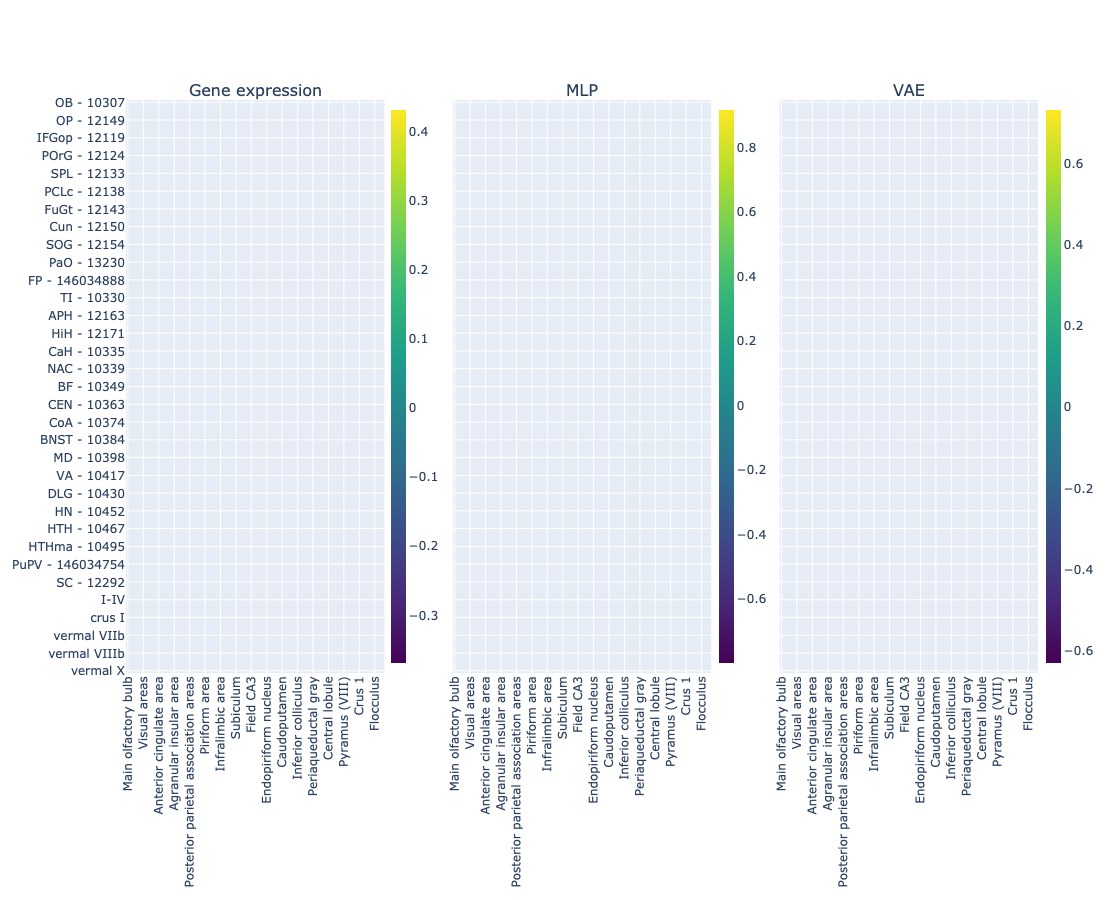

In [40]:
# Plot Similarity matrices

import plotly.express as px
from plotly import graph_objects as go
import plotly.subplots
from matplotlib import cm


fig3 = plotly.subplots.make_subplots(rows=1, cols=3, shared_yaxes=True, horizontal_spacing=0.075, subplot_titles=['Gene expression','MLP','VAE'])

fig3.add_trace(go.Heatmap(z=sim_genes, x=mouse_labels_order['Region'][index_mouse], y=vae_h['Region'][index_human],coloraxis="coloraxis1"), 1,1)
fig3.add_trace(go.Heatmap(z=sim_mlp, x=mouse_labels_order['Region'][index_mouse], y=vae_h['Region'][index_human],coloraxis="coloraxis2"),1,2)
fig3.add_trace(go.Heatmap(z=sim_vae, x=mouse_labels_order['Region'][index_mouse],y=vae_h['Region'][index_human],coloraxis="coloraxis3"), 1,3)
fig3.update_layout(autosize=True, width=1100, height=900,
                   coloraxis1={'colorscale':'viridis', 'colorbar_x':0.28, 'colorbar_thickness':15},
                   coloraxis2 = {'colorscale':'viridis', 'colorbar_x':0.639, 'colorbar_thickness':15},
                   coloraxis3 = {'colorscale':'viridis', 'colorbar_x':0.998, 'colorbar_thickness':15} )
fig3.update_yaxes(autorange='reversed')
fig3.update_xaxes(tickangle=-90)

Text(0, 0.5, 'Unit-scaled similarity')

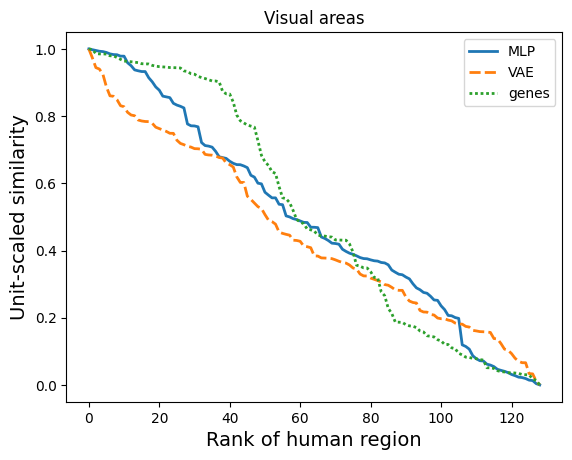

In [51]:
# Plot unit-scaled similarity profiles

scaler=MinMaxScaler(feature_range=(0,1))

sim_mlp = scaler.fit_transform(sim_mlp)
sim_genes = scaler.fit_transform(sim_genes)
sim_vae = scaler.fit_transform(sim_vae)

import scipy.stats
index=4 
data_1 = pd.DataFrame({"MLP":np.sort(sim_mlp[:,index])[::-1], "VAE": np.sort(sim_vae[:,index])[::-1], 'genes': np.sort(sim_genes[:,index])[::-1]})

sns_plot = sns.lineplot(data=data_1, linewidth=2)
sns_plot.set(title="%s" % mouse_labels_order.reindex(index_mouse).reset_index()['Region'][index])
sns_plot.set_xlabel('Rank of human region', fontdict={'size': 14})
sns_plot.set_ylabel('Unit-scaled similarity', fontdict={'size': 14})

In [63]:
#  UMAP plots
import umap.umap_ as umap
import umap.plot

reducer = umap.UMAP(n_components=2, random_state=1)
genes_umap = pd.DataFrame(reducer.fit_transform(np.array(pd.concat(genes_m_data, genes_h_data))))
mlp_umap = pd.DataFrame(reducer.fit_transform(np.array(pd.concat(mlp_m_data, mlp_h_data))))
vae_umap = pd.DataFrame(reducer.fit_transform(np.array(pd.concat(vae_m_data, vae_h_data))))

class_m_h = np.zeros(196).astype(str)
class_m_h[0:67]='mouse'
class_m_h[67:]='human'



genes_umap['Species'] = class_m_h
genes_umap['Regions'] = pd.concat([mouse_5, human_5])[0]



/well/mars/users/uvy786/conda/skylake/envs/abagen/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

/well/mars/users/uvy786/conda/skylake/envs/abagen/lib/python3.12/site-packages/umap/plot.py:20: UserWarning:

The umap.plot package requires extra plotting libraries to be installed.
    You can install these via pip using

    pip install umap-learn[plot]

    or via conda using

     conda install pandas matplotlib datashader bokeh holoviews colorcet scikit-image
    



ImportError: umap.plot requires pandas matplotlib datashader bokeh holoviews scikit-image and colorcet to be installed

In [ ]:
pd.concat([mouse_5, human_5], ignore_index=True)